# Modelo de Machine Learning para competencia "House Prices - Advanced Regression Techniques"

Author: Ricardo R. Condado A01379299

In [2]:
# Importamos librerías
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
# Cargaos el archivo
df = pd.read_csv('train.csv')
df2 = pd.read_csv('test.csv')
df3 = pd.read_csv('sample_submission.csv')

In [6]:
# Analizamos su contenido
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


Analizamos y tenemos 81 columnas, y más de 4000 datos de entrada. Se creó un mapa de calor de puntos SNS, esto permite ver los valores núlos, y con ello determinamos que existen muchos campos con valores núlos.

<Axes: >

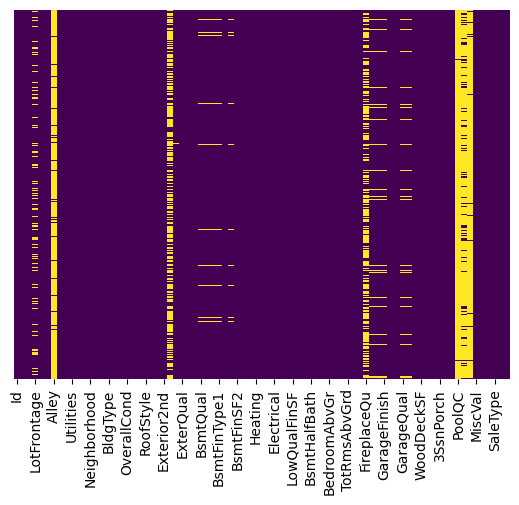

In [4]:
sns.heatmap(df.isnull(), yticklabels=False, cbar=False, cmap='viridis')

<Axes: >

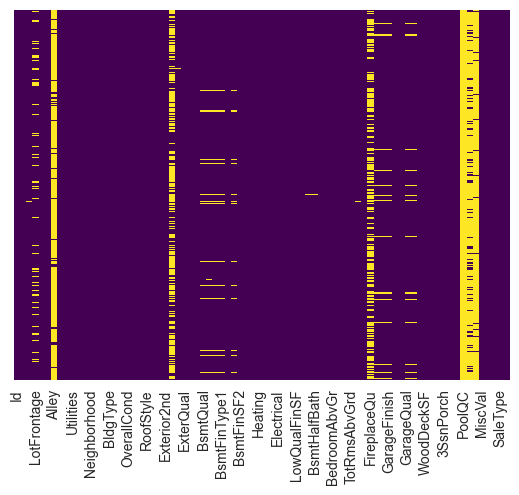

In [8]:
sns.heatmap(df2.isnull(), yticklabels=False, cbar=False, cmap='viridis')

<Axes: >

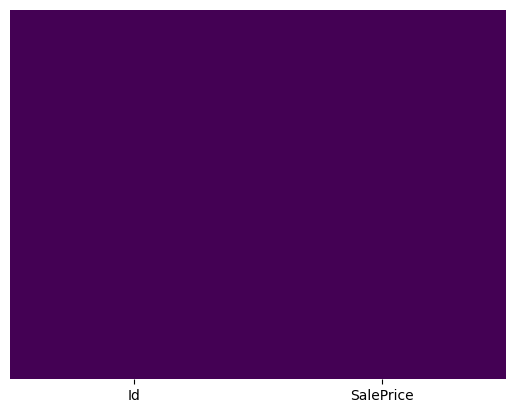

In [5]:
sns.heatmap(df3.isnull(), yticklabels=False, cbar=False, cmap='viridis')

In [6]:
df.isnull().sum()

Id                 0
MSSubClass         0
MSZoning           0
LotFrontage      259
LotArea            0
                ... 
MoSold             0
YrSold             0
SaleType           0
SaleCondition      0
SalePrice          0
Length: 81, dtype: int64

In [7]:
df.shape

(1460, 81)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [9]:
from sklearn.impute import SimpleImputer

# Define numéricas y categóricas
num_features = df.select_dtypes(include=['int64', 'float64']).columns.drop("SalePrice")
cat_features = df.select_dtypes(include=['object']).columns

# Imputación para características numéricas
num_imputer = SimpleImputer(strategy='median')
df[num_features] = num_imputer.fit_transform(df[num_features])

# Imputación para características categóricas
cat_imputer = SimpleImputer(strategy='most_frequent')
df[cat_features] = cat_imputer.fit_transform(df[cat_features])

## Procedemos al preprocesamiento de datos:

In [10]:
# Transformación logarítmica para 'GrLivArea'
df['GrLivArea'] = np.log1p(df['GrLivArea'])

# Añadir una característica de 'Age' para la vivienda
df['Age'] = df['YrSold'] - df['YearBuilt']

# Codificación one-hot
df = pd.get_dummies(df, drop_first=True)

## Preparación de los Datos de Prueba

In [14]:
# Aplicar el mismo preprocesamiento y la ingeniería de características al conjunto de prueba
df2[num_features] = num_imputer.transform(df2[num_features])
df2[cat_features] = cat_imputer.transform(df2[cat_features])
df2['GrLivArea'] = np.log1p(df2['GrLivArea'])
df2['Age'] = df2['YrSold'] - df2['YearBuilt']
test_data = pd.get_dummies(df2, drop_first=True)

# Asegurarse de que ambos conjuntos de datos tengan las mismas columnas
final_train, final_test = df2.align(test_data, join='left', axis=1)
final_test = final_test.fillna(0)

In [17]:
# 1. Separa la columna `SalePrice` del conjunto de entrenamiento antes de la alineación
y_train = df['SalePrice'].copy()
train_data_without_target = df.drop(columns=['SalePrice'])

# 2. Realiza la codificación one-hot
train_encoded = pd.get_dummies(train_data_without_target, drop_first=True)
test_encoded = pd.get_dummies(test_data, drop_first=True)

# Alinea los conjuntos de datos
final_train, final_test = train_encoded.align(test_encoded, join='left', axis=1)

# Rellena los valores faltantes en final_test con 0 (esto puede ser necesario si el conjunto de prueba tiene columnas faltantes después de la codificación one-hot)
final_test.fillna(0, inplace=True)

# 3. Añade de nuevo la columna `SalePrice` a `final_train`
final_train['SalePrice'] = y_train


## Entrenamiento del Modelo y Predicciones

In [27]:
import xgboost as xgb

# Preparar los datos para el entrenamiento
X_train = final_train.drop("SalePrice", axis=1)
y_train = np.log1p(final_train["SalePrice"])

# Entrenar el modelo XGBRegressor
xgb_regressor = xgb.XGBRegressor(n_estimators=1000, learning_rate=0.05, n_jobs=4)
xgb_regressor.fit(X_train, y_train)

# Hacer predicciones en el conjunto de datos de prueba
test_preds = xgb_regressor.predict(final_test)
test_preds_original = np.expm1(test_preds)

In [28]:
print(test_preds_original[:])

[118640.29 122552.84 132741.38 ... 133428.27 103115.96 177249.72]


In [35]:
# Hacer predicciones en el conjunto de datos de prueba
test_preds = xgb_regressor.predict(final_test)
test_preds_original = np.expm1(test_preds)

# Comparar las predicciones con los valores verdaderos en una tabla
comparison_df = pd.DataFrame({
    "True Values": df3["SalePrice"],
    "Predictions": test_preds_original
})

print(comparison_df.head(10))

     True Values    Predictions
0  169277.052498  118640.289062
1  187758.393989  122552.843750
2  183583.683570  132741.375000
3  179317.477511  157644.234375
4  150730.079977  158735.718750
5  177150.989247  133898.640625
6  172070.659229  154991.031250
7  175110.956520  135417.968750
8  162011.698832  161450.734375
9  160726.247831  121103.562500


In [36]:
from sklearn.metrics import mean_squared_error

# Calcula el error cuadrático medio en la escala logarítmica
mse = mean_squared_error(np.log1p(sample_submission["SalePrice"]), np.log1p(test_preds_original))

# Toma la raíz cuadrada para obtener el RMSE
rmse = np.sqrt(mse)

print(f"RMSE en escala logarítmica: {rmse}")


RMSE en escala logarítmica: 0.4545397999782664
